### Hybrid Base Model: MNIST Data

Added Quantum layer based on custom defined quantum circuit in the classical base model cnn architecture

In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 69.8 MB/s eta 0:00:00


In [1]:
# Required imports
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers, initializers

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix as cmatrix

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# loading the data as train and test
data = np.load('drive/MyDrive/gsoc_dataset/electron-photon-pairs.npz', allow_pickle=True)

pairs_train = data["pairs_train"]
labels_train = data["labels_train"]
pairs_test = data["pairs_test"]
labels_test = data["labels_test"]

print(pairs_train.shape, pairs_test.shape)
print(labels_train.shape, labels_test.shape)

(796800, 2, 8, 8, 1) (199200, 2, 8, 8, 1)
(796800,) (199200,)


In [2]:
# Defining quantum circuit for quantum layer
n_qubits = 8
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

(<Figure size 3100x900 with 1 Axes>, <Axes: >)

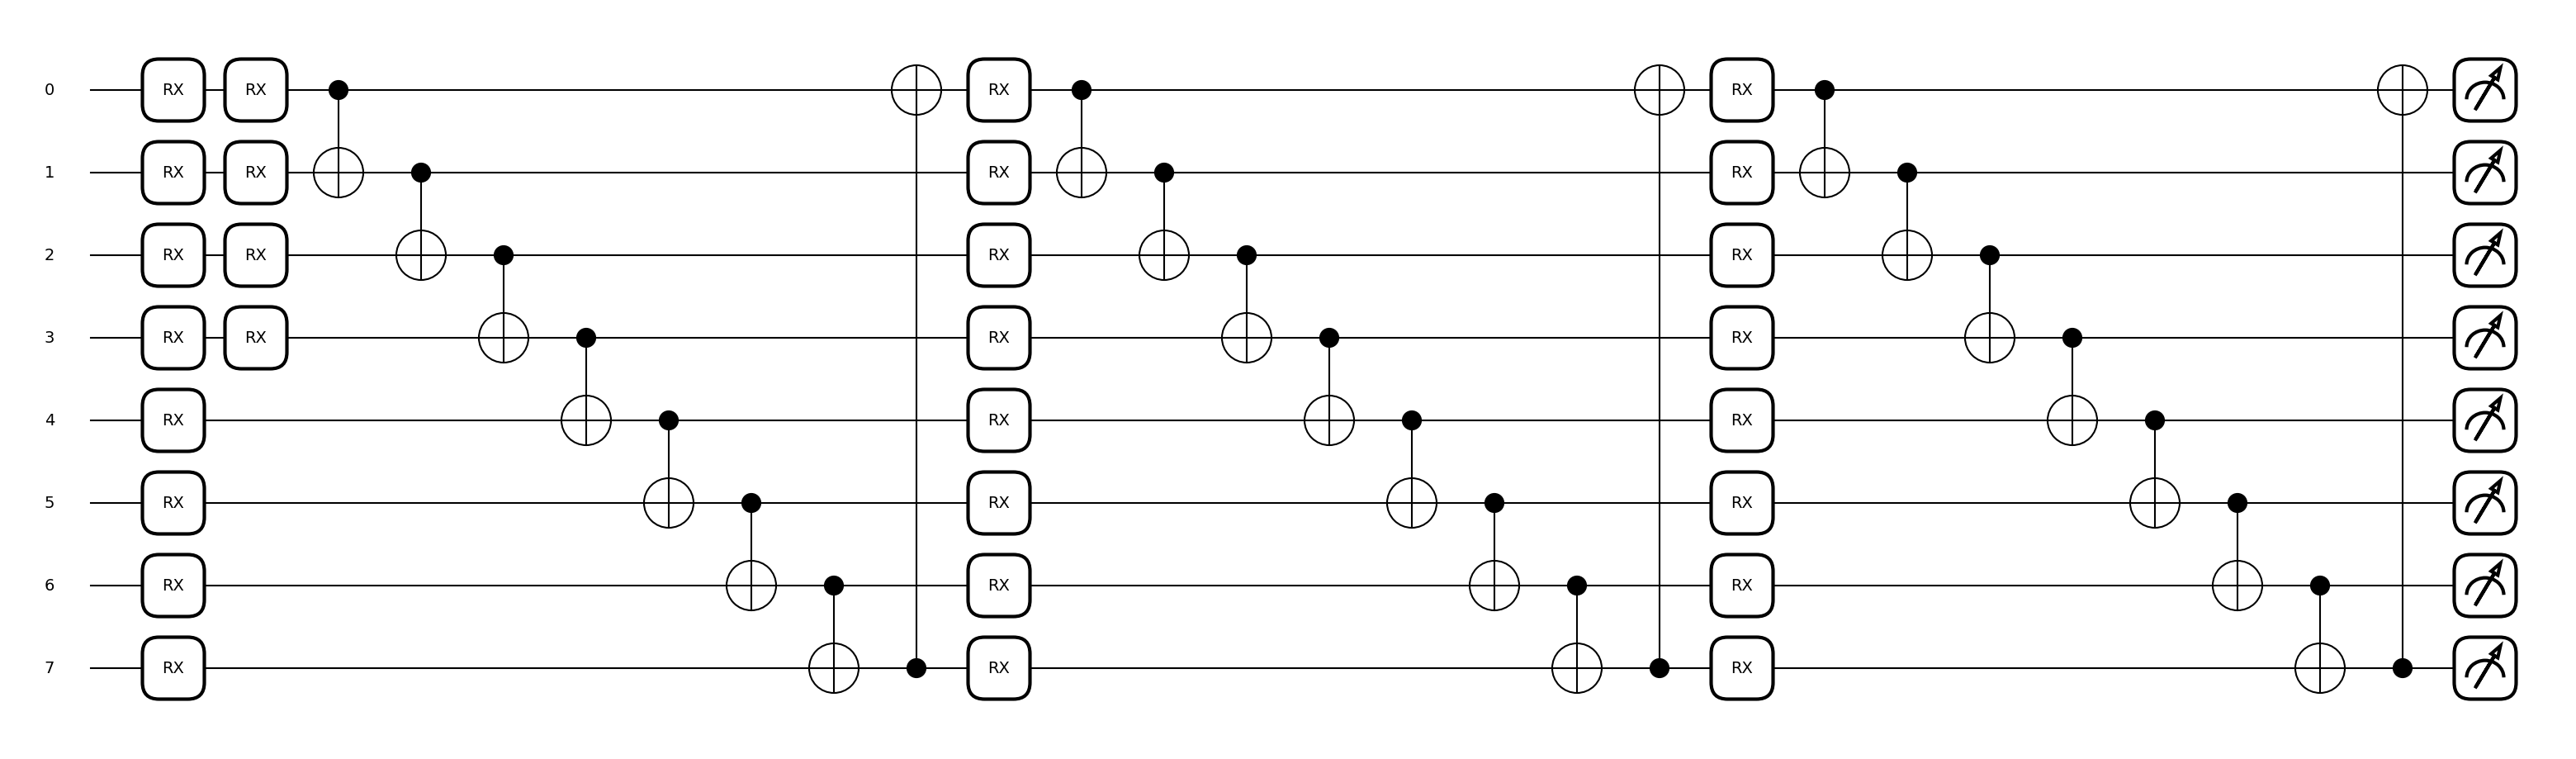

In [3]:
# Plotting a sample circuit with random weights for visualization
weights = np.random.random((n_layers, n_qubits))
X=[1,2,3,4]
qml.draw_mpl(quantum_circuit, expansion_strategy="device")(X,weights)
# print(qml.draw(circuit, expansion_strategy="device")(X))

In [9]:
# Define trainable weights for the quantum circuit (will be used in training)
weight_shapes = {"weights": (n_layers, n_qubits)}
quantum_layer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

In [10]:
# Base model from classical nb, adding qlayer in between
def create_quantum_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializers.HeNormal())) # Conv layer 1
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Conv layer 2
    model.add(layers.Dropout((0.5)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))

    # ------ Quantum layer added in nb 2 classical base architecture
    # Reducing dimensions to match n_qubits
    model.add(layers.Dense(n_qubits))
    # Quantum layer
    model.add(quantum_layer)
    # Dense layer after quantum layer
    model.add(layers.Dense(n_qubits, activation='relu'))
    # --------------------------------------------------------------
    return model

In [11]:
# Contrastive Pair loss
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_quantum_cnn(input_shape)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])


    model = models.Model([input_0, input_1], distance)

    return model

In [12]:
# Training
tf.get_logger().setLevel('ERROR')

# checkpoint_path = "hybrid_cnn_base_1_ep/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='hybrid_model.h5', save_weights_only=True,verbose=1)


input_shape = pairs_train.shape[2:]
siamese_network = create_siamese_network(input_shape)

siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam(learning_rate=1e-3))

history = siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=20,
    batch_size=10000,
    callbacks=[cp_callback]
)

Epoch 1/20
80/80 [==============================] - ETA: 0s - loss: 0.8810
Epoch 1: saving model to hybrid_model.h5
80/80 [==============================] - 476s 6s/step - loss: 0.8810 - val_loss: 0.7120
Epoch 2/20
80/80 [==============================] - ETA: 0s - loss: 0.4050
Epoch 2: saving model to hybrid_model.h5
80/80 [==============================] - 466s 6s/step - loss: 0.4050 - val_loss: 0.5561
Epoch 3/20
80/80 [==============================] - ETA: 0s - loss: 0.3133
Epoch 3: saving model to hybrid_model.h5
80/80 [==============================] - 478s 6s/step - loss: 0.3133 - val_loss: 0.5165
Epoch 4/20
80/80 [==============================] - ETA: 0s - loss: 0.2905
Epoch 4: saving model to hybrid_model.h5
80/80 [==============================] - 466s 6s/step - loss: 0.2905 - val_loss: 0.5066
Epoch 5/20
80/80 [==============================] - ETA: 0s - loss: 0.2845
Epoch 5: saving model to hybrid_model.h5
80/80 [==============================] - 466s 6s/step - loss: 0.2845

In [13]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 sequential (Sequential)     (None, 8)                    23592     ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None,)                      0         ['sequential[0][0]',      

### Model Evaluation

<Axes: title={'center': 'Learning History'}>

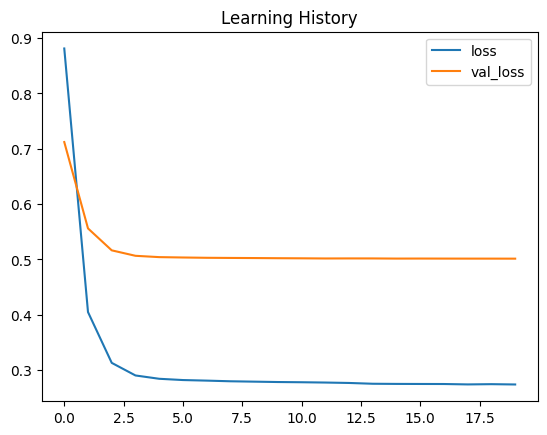

In [14]:
pd.DataFrame(history.history).plot(title="Learning History")